## Import Data ##

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pillow_avif
import seaborn_image as isns
import seaborn as sn
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import random
from scipy.stats import *
import time
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [5]:
image_path = []
labels = []

dir_path = os.getcwd()

for i in os.listdir(f"{dir_path}/Time of Day"):
    for label in os.listdir(f"{dir_path}/Time of Day/{i}"):
        for image in os.listdir(f"{dir_path}/Time of Day/{i}"):
            image_path.append(f"{dir_path}/Time of Day/{i}/{image}")
            labels.append(i)

df = pd.DataFrame(zip(image_path, labels), columns = ["image_path", "labels"])
df = df.drop_duplicates().reset_index(drop=True)
df

,image_path,labels
0,/Users/jay/Jupyter Projects/Time of Day/Time o...,nighttime
1,/Users/jay/Jupyter Projects/Time of Day/Time o...,nighttime
2,/Users/jay/Jupyter Projects/Time of Day/Time o...,nighttime
3,/Users/jay/Jupyter Projects/Time of Day/Time o...,nighttime
4,/Users/jay/Jupyter Projects/Time of Day/Time o...,nighttime
...,...,...
2656,/Users/jay/Jupyter Projects/Time of Day/Time o...,daytime
2657,/Users/jay/Jupyter Projects/Time of Day/Time o...,daytime
2658,/Users/jay/Jupyter Projects/Time of Day/Time o...,daytime
2659,/Users/jay/Jupyter Projects/Time of Day/Time o...,daytime


## Statistical Modeling ##

Shape:  (2661, 2)

Counts:
 labels
sunrise      985
daytime      920
nighttime    756
Name: count, dtype: int64



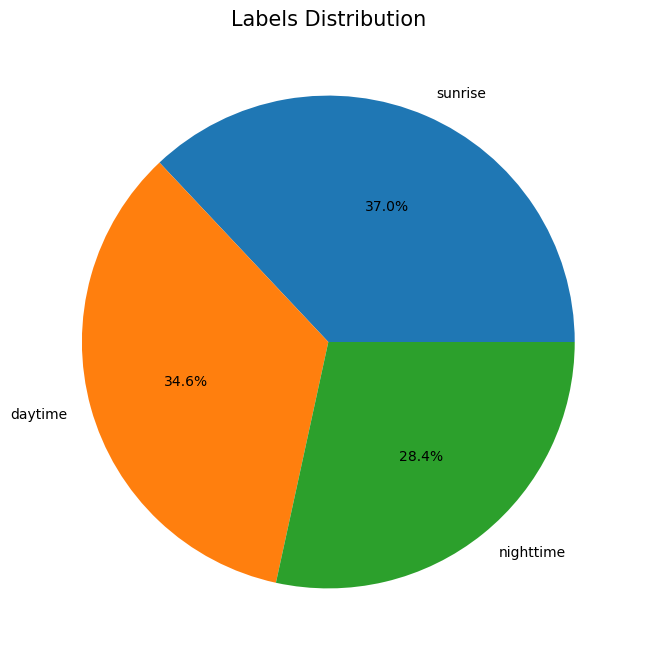

In [7]:
print("Shape: ", df.shape)
print("\nCounts:\n", df["labels"].value_counts())

print()

plt.figure(figsize=(8,8))
plt.pie(df["labels"].value_counts(), labels = df["labels"].value_counts().index, autopct="%1.1f%%")
plt.title("Labels Distribution")
plt.show()

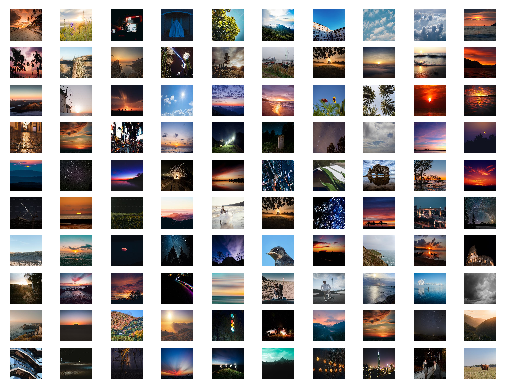

In [9]:
#100 random images
n_rows = 10
n_cols = 10

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis("off")

plt.show()


Description for Image 1:

No. of Obs. : 50176
Min. Value : 0
Max. Value : 243
Mean : 46.5827487244898
Variance : 2607.504223762749
Skewness : 1.1177857690102635

Description for Image 2:

No. of Obs. : 50176
Min. Value : 0
Max. Value : 210
Mean : 68.47233737244898
Variance : 2102.115547668619
Skewness : 0.7544663700655988

Description for Image 3:

No. of Obs. : 50176
Min. Value : 8
Max. Value : 255
Mean : 58.905592315051024
Variance : 544.074216059719
Skewness : 1.1947736166057898

Description for Image 4:

No. of Obs. : 50176
Min. Value : 0
Max. Value : 252
Mean : 12.130719866071429
Variance : 225.30574207072124
Skewness : 3.728109018138795

Description for Image 5:

No. of Obs. : 50176
Min. Value : 0
Max. Value : 255
Mean : 82.63653938137755
Variance : 4563.014819505694
Skewness : 0.979067973843631


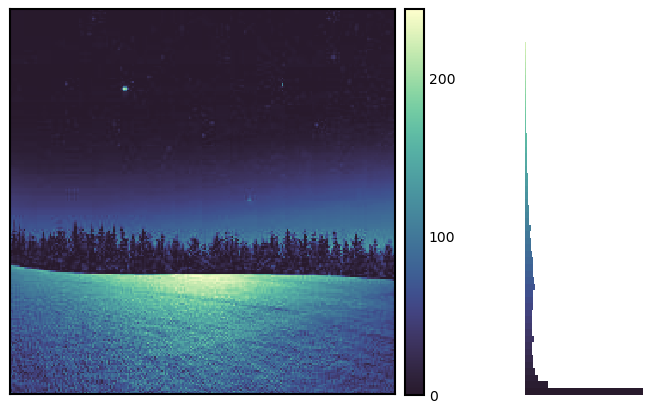

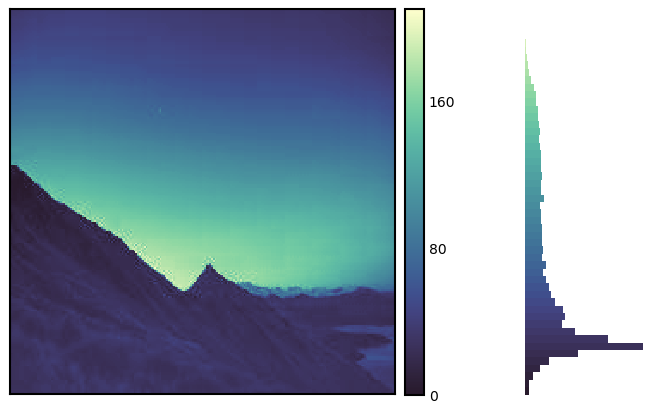

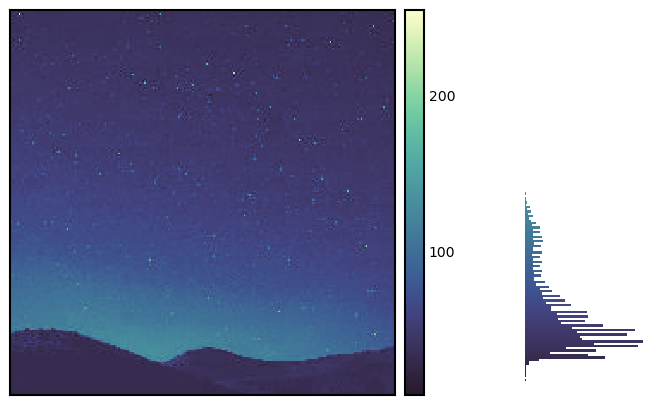

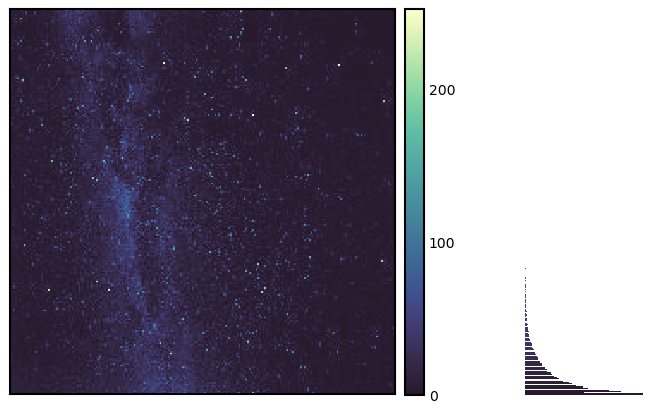

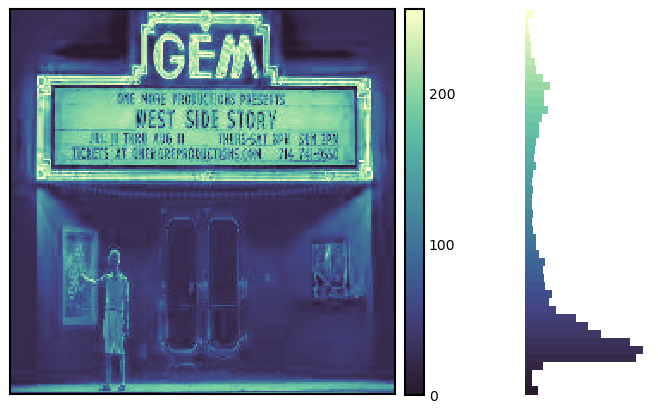

In [11]:
for i in range(5):
    pol = plt.imread(df.iloc[0+i, 0])[:, :, 0]
    print(f"\nDescription for Image {i+1}:\n")
    print("="*50)
    f = isns.imghist(pol, describe=True)

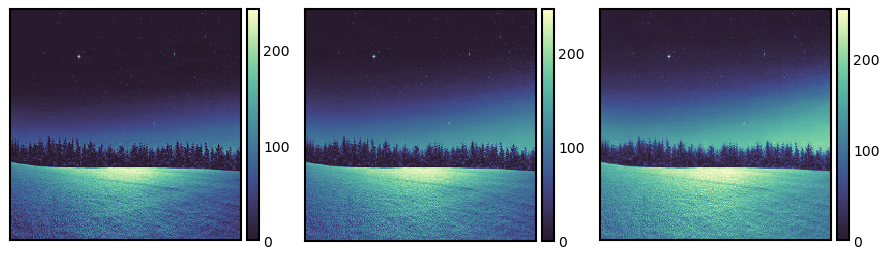

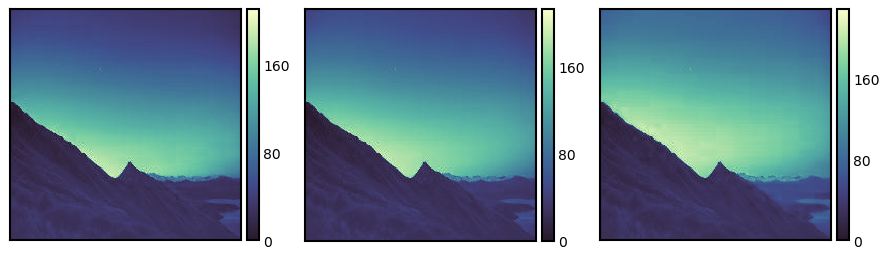

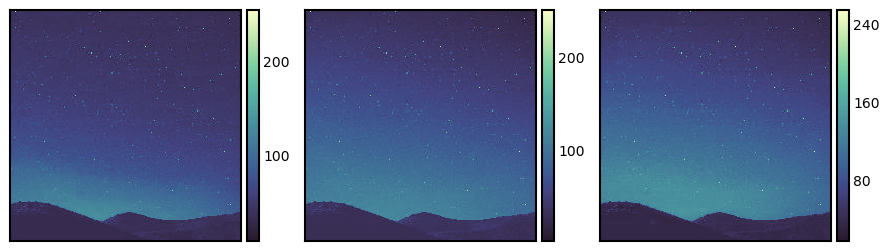

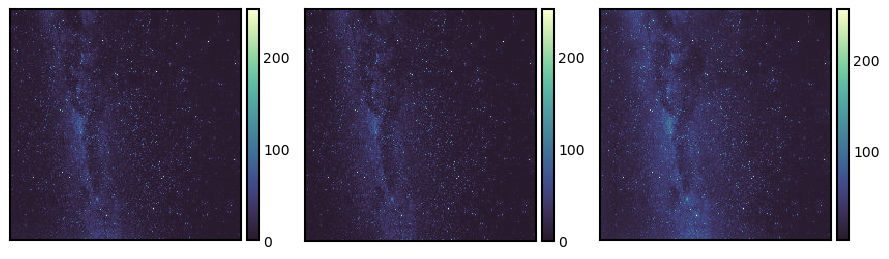

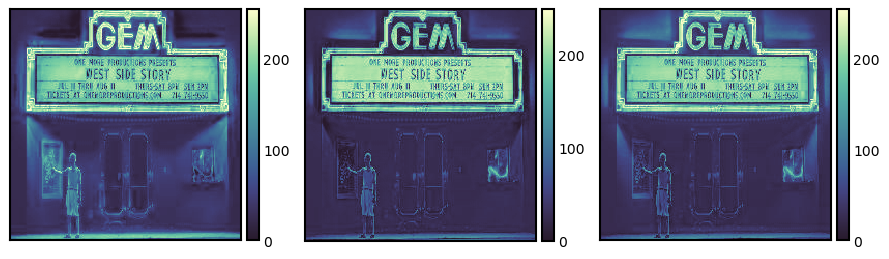

In [13]:
for i in range(5):
    ims = plt.imread(df.iloc[0+i, 0])
    grid = isns.ImageGrid(ims)

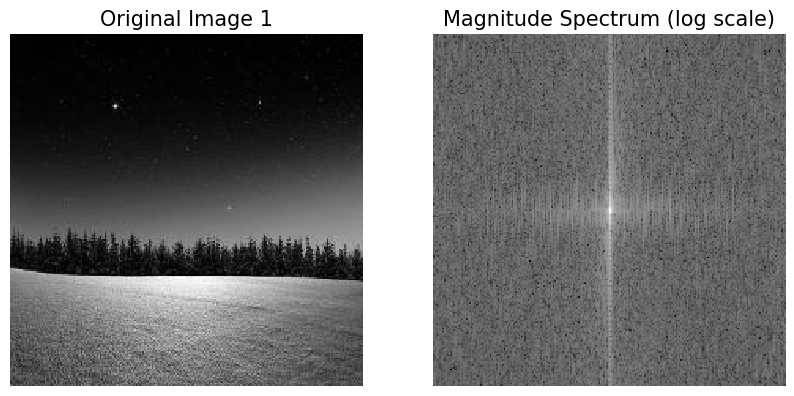

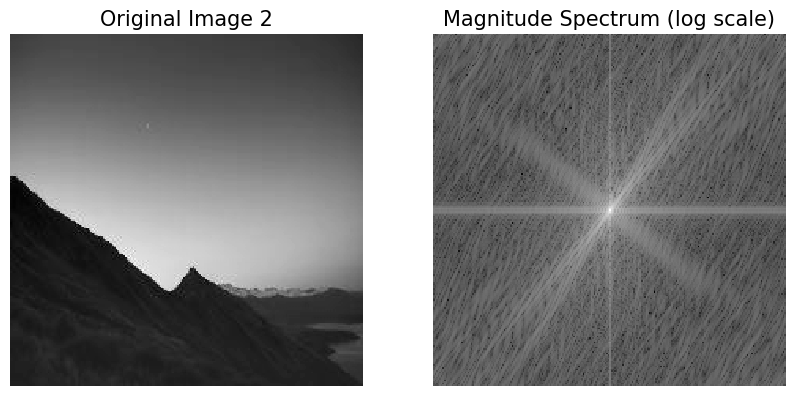

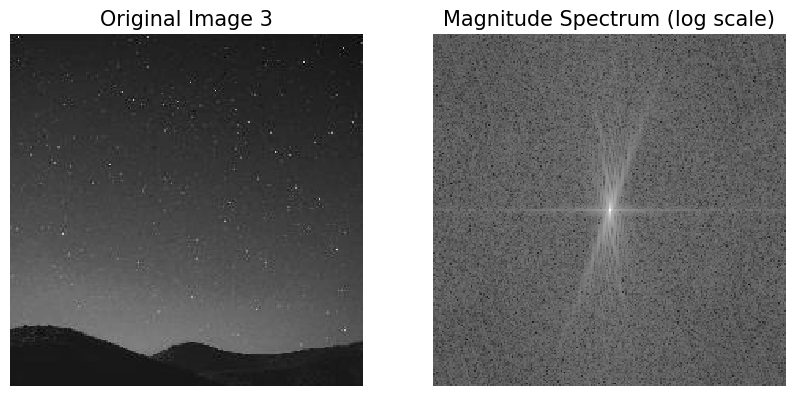

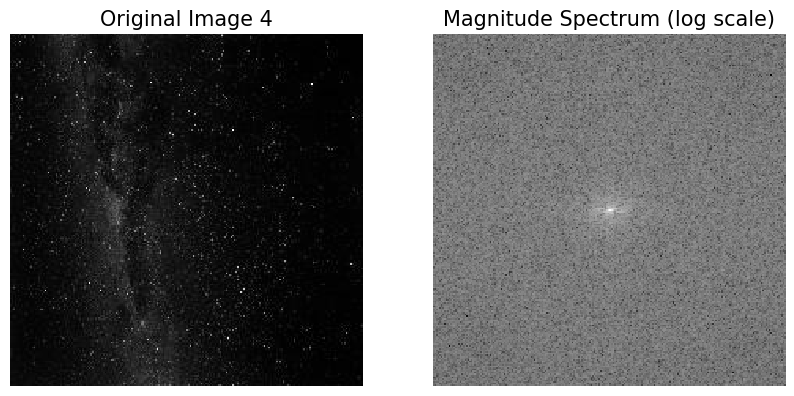

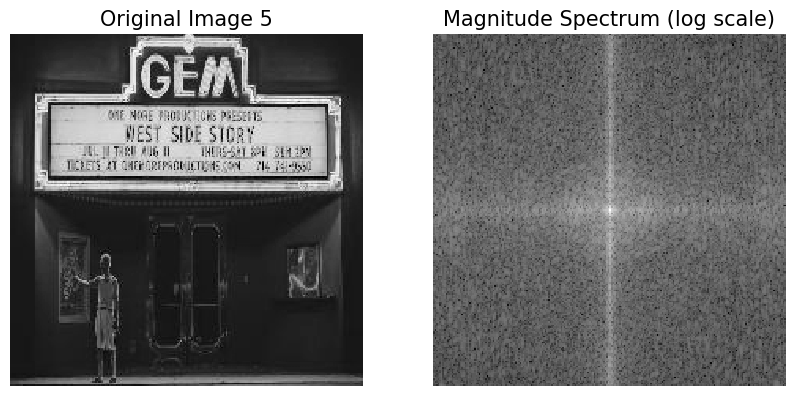

In [15]:
for i in range(5):
    img_data = plt.imread(df.iloc[0+i, 0])
    
    if len(img_data.shape) == 3:
        img_data = np.mean(img_data, axis=2)
    
    ft = np.fft.fft2(img_data)
    
    ft_shifted = np.fft.fftshift(ft)
    
    magnitude_spectrum = np.abs(ft_shifted)
    
    magnitude_spectrum_log = np.log1p(magnitude_spectrum)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_data, cmap="gray")
    plt.title(f"Original Image {i+1}")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum_log, cmap="gray")
    plt.title("Magnitude Spectrum (log scale)")
    plt.axis("off")
    
    plt.show()

Number of clusters in image 1: 1
Number of clusters in image 2: 1
Number of clusters in image 3: 1
Number of clusters in image 4: 1
Number of clusters in image 5: 1


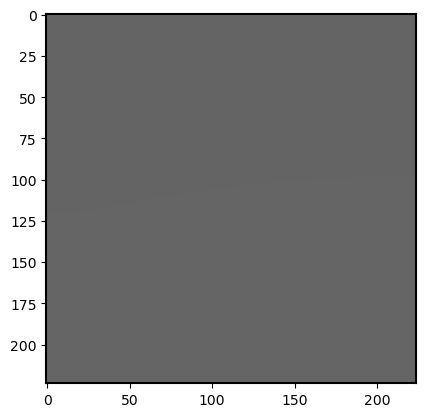

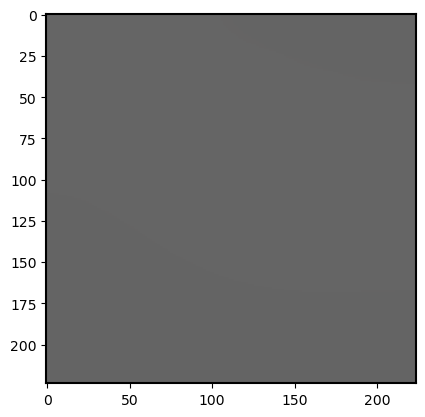

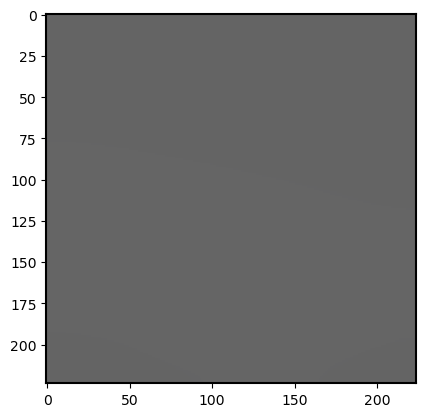

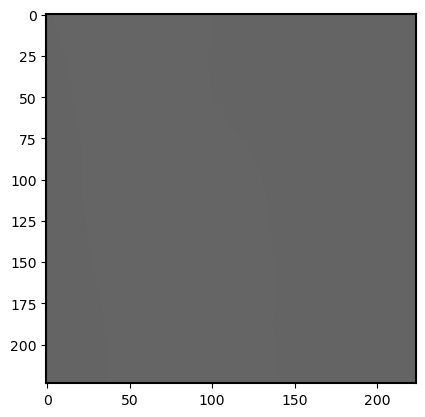

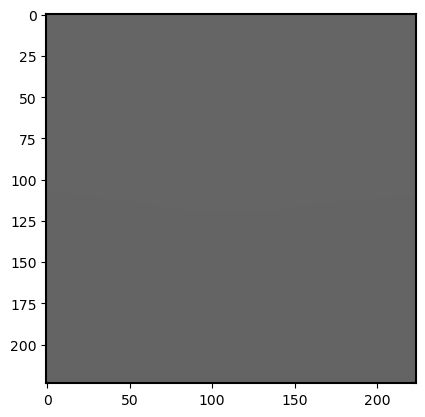

In [17]:
from scipy import ndimage

for i in range(5):
    plt.figure()
    
    im = Image.open(df.iloc[i, 0])
    im2 = ndimage.gaussian_filter(im, sigma=np.std(np.array(im)))
    plt.imshow(im2);
    mask = im2 > im2.mean()
    label_im, nb_labels = ndimage.label(mask)
    print(f"Number of clusters in image {i+1}: {nb_labels}")
    brightness = 100
    plt.imshow(label_im+brightness);
    i += 1

## Training Model ##

In [19]:
train = df.sample(frac = 0.7)
test = df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(1863, 2)
(399, 2)
(399, 2)


In [21]:
class NumpyOperations:
    def __init__(self, augment_probability=0.15, apply_linear_ops = False):
        self.augment_probability = augment_probability
        self.apply_linear_ops = apply_linear_ops

    def __call__(self, image):
        image_np = np.array(image)
        
        image_np = image_np / 255
        
        if random.random() < self.augment_probability:
            image_np = np.rot90(image_np)
            
        if random.random() < self.augment_probability:
            image_np = np.rot90(image_np, k=3)
            
        if random.random() < self.augment_probability:
            image_np = np.flip(image_np)
            
        if random.random() < self.augment_probability:
            image_np = np.fliplr(image_np)
                        
        if random.random() < self.augment_probability:
            image_np = np.flipud(image_np)
                        
        if random.random() < self.augment_probability:
            brightness = random.randrange(10, 100)
            image_np = image_np.astype(np.uint16) + brightness
        
        if self.apply_linear_ops:
            image_np = np.transpose(image_np, (1, 0, 2))
        
        image_np = np.clip(image_np, 0, 255)
        image_pil = Image.fromarray((image_np * 255).astype(np.uint8))
        
        return image_pil

In [23]:
le = LabelEncoder()
le.fit(df["labels"])

transform = transforms.Compose([
    transforms.Resize([128, 128]),
    NumpyOperations(),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [25]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment_probability=0.15):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.augment_probability = augment_probability
        self.operation_transform = NumpyOperations(augment_probability, apply_linear_ops=False) #Can toggle the linal ops
        self.labels = torch.tensor(le.transform(dataframe["labels"])).to(device)
        self.original_len = len(dataframe)

    def __len__(self):
        return 2 * self.original_len

    def __getitem__(self, idx):
        is_augmented = idx >= self.original_len
        real_idx = idx % self.original_len

        img_path = self.dataframe.iloc[real_idx, 0]
        label = self.labels[real_idx]
        image = Image.open(img_path).convert("RGB")

        if is_augmented:
            image = self.operation_transform(image)

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [27]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)

print("New Train Dataset Size:", len(train_dataset))
print("New Validation Dataset Size:", len(val_dataset))
print("New Test Dataset Size:", len(test_dataset))

New Train Dataset Size: 3726
New Validation Dataset Size: 798
New Test Dataset Size: 798


In [45]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 20

In [47]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [49]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128*16*16), 128)

        self.output = nn.Linear(128, len(df["labels"].unique()))

    def forward(self, x):
        x = self.conv1(x) #(32, 128, 128)
        x = self.pooling(x) #(32, 64, 64)
        x = self.relu(x)

        x = self.conv2(x) #(64, 64, 64)
        x = self.pooling(x) #(64, 32, 32)
        x = self.relu(x)

        x = self.conv3(x) #(128, 32, 32)
        x = self.pooling(x) #(128, 16, 16) same as number in self.linear
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

In [51]:
model = Net().to(device)

In [53]:
summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─ReLU: 1-5                              --
├─Flatten: 1-6                           --
├─Linear: 1-7                            4,194,432
├─Linear: 1-8                            387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [57]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

start_time = time.time()

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            
            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc
        
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/val_dataset.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1}/{EPOCHS} 
    Training Loss: {round(total_loss_train/1000, 4)} 
    Training Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/1000, 4)} 
    Validation Accuracy: {round(total_acc_val/val_dataset.__len__()*100, 4)}''')

    print("="*50)

print("Training Time is: ", round((time.time() - start_time), 4), " Seconds")

Epoch no. 1/20 
    Training Loss: 0.1869 
    Training Accuracy: 61.9968 
    Validation Loss: 0.0378 
    Validation Accuracy: 68.4211
Epoch no. 2/20 
    Training Loss: 0.1496 
    Training Accuracy: 70.7729 
    Validation Loss: 0.0315 
    Validation Accuracy: 74.0602
Epoch no. 3/20 
    Training Loss: 0.1491 
    Training Accuracy: 69.8604 
    Validation Loss: 0.0306 
    Validation Accuracy: 74.0602
Epoch no. 4/20 
    Training Loss: 0.1423 
    Training Accuracy: 71.9538 
    Validation Loss: 0.0306 
    Validation Accuracy: 73.3083
Epoch no. 5/20 
    Training Loss: 0.1362 
    Training Accuracy: 72.8127 
    Validation Loss: 0.0309 
    Validation Accuracy: 71.9298
Epoch no. 6/20 
    Training Loss: 0.1347 
    Training Accuracy: 73.2958 
    Validation Loss: 0.0309 
    Validation Accuracy: 73.6842
Epoch no. 7/20 
    Training Loss: 0.1294 
    Training Accuracy: 74.5035 
    Validation Loss: 0.0308 
    Validation Accuracy: 74.9373
Epoch no. 8/20 
    Training Loss: 0.1306

In [58]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)
        
        acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += acc
        
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

print(f'''Accuracy Score: {round((total_acc_test/test_dataset.__len__())*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 74.0602 
Loss: 0.028


## Post-Training Analysis ##

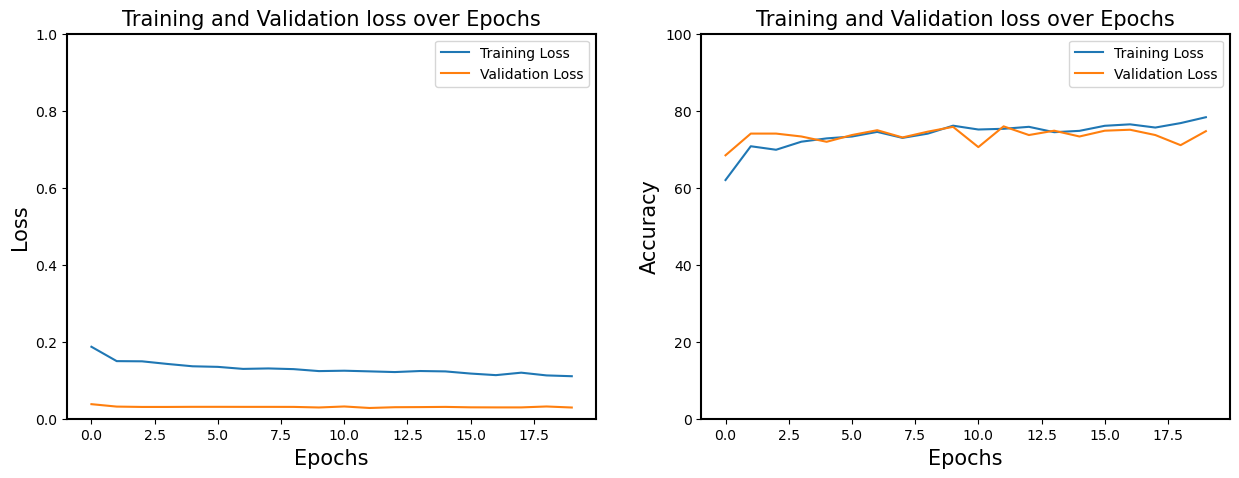

In [61]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [63]:
torch.save(model.state_dict(), "model.pth")

In [65]:
loaded_model = Net().to(device)
loaded_model.load_state_dict(torch.load("model.pth"))
loaded_model.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=32768, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
)

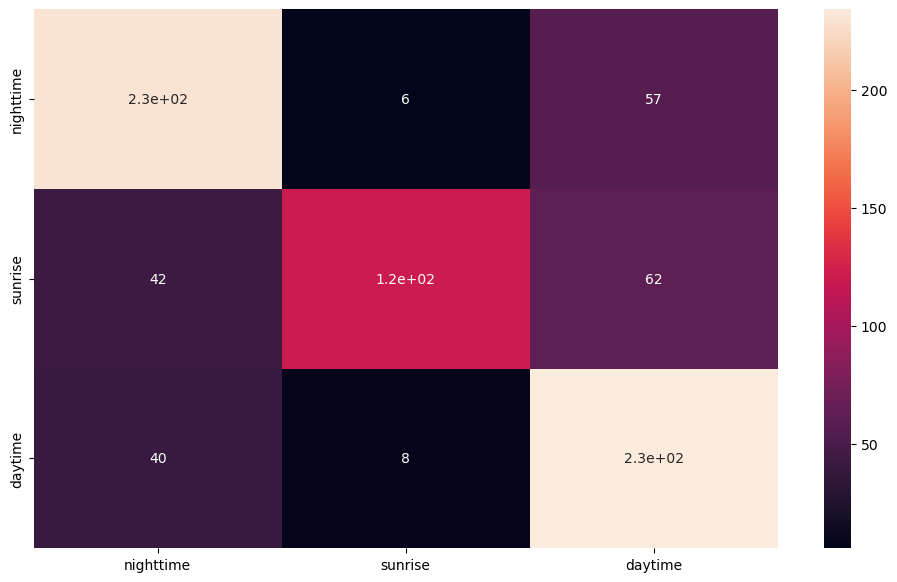

In [67]:
y_pred = []
y_true = []

for inputs, labels in test_loader:
        output = loaded_model(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

classes = df["labels"].unique()

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True);

In [99]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)
    
    model_prediction = loaded_model(image.unsqueeze(0))
    model_prediction = torch.argmax(model_prediction, axis = 1).item()
    
    return le.inverse_transform([model_prediction])

['daytime']


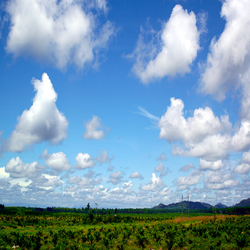

In [101]:
path1 = f"{dir_path}/Day.jpg"
print(predict_image(path1))
Image.open(path1).convert("RGB").resize([250, 250])

['nighttime']


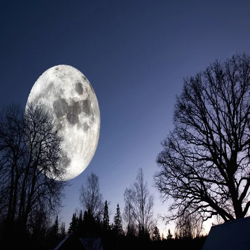

In [103]:
path2 = f"{dir_path}/night.jpg"
print(predict_image(path2))
Image.open(path2).convert("RGB").resize([250, 250])

['sunrise']


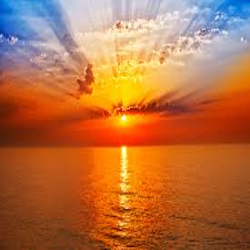

In [105]:
path3 = f"{dir_path}/Rise.jpeg"
print(predict_image(path3))
Image.open(path3).convert("RGB").resize([250, 250])